In [1]:
!pip install torchio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import torchvision
import tarfile
import pandas as pd
import torch.nn as nn
import numpy as np
import os.path
import shutil
import torchio as tio
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
df = pd.read_csv('/content/drive/MyDrive/informazioni_pazienti.csv', index_col = 'ID')
print(df)

                    OS
ID                    
UPENN-GBM-00002_11   0
UPENN-GBM-00006_11   1
UPENN-GBM-00008_11   1
UPENN-GBM-00009_11   1
UPENN-GBM-00011_11   1
...                 ..
UPENN-GBM-00597_11   0
UPENN-GBM-00601_11   0
UPENN-GBM-00602_11   0
UPENN-GBM-00604_11   0
UPENN-GBM-00611_11   1

[334 rows x 1 columns]


In [5]:
patients_list = [f.name for f in os.scandir('/content/drive/MyDrive/dataset') if f.is_dir()]
subjects_list = []
print(patients_list)

['UPENN-GBM-00006_11', 'UPENN-GBM-00009_11', 'UPENN-GBM-00011_11', 'UPENN-GBM-00002_11', 'UPENN-GBM-00014_11', 'UPENN-GBM-00012_11', 'UPENN-GBM-00020_11', 'UPENN-GBM-00016_11', 'UPENN-GBM-00008_11', 'UPENN-GBM-00018_11', 'UPENN-GBM-00040_11', 'UPENN-GBM-00033_11', 'UPENN-GBM-00041_11', 'UPENN-GBM-00021_11', 'UPENN-GBM-00034_11', 'UPENN-GBM-00035_11', 'UPENN-GBM-00031_11', 'UPENN-GBM-00029_11', 'UPENN-GBM-00022_11', 'UPENN-GBM-00030_11', 'UPENN-GBM-00054_11', 'UPENN-GBM-00043_11', 'UPENN-GBM-00059_11', 'UPENN-GBM-00062_11', 'UPENN-GBM-00047_11', 'UPENN-GBM-00060_11', 'UPENN-GBM-00063_11', 'UPENN-GBM-00058_11', 'UPENN-GBM-00045_11', 'UPENN-GBM-00057_11', 'UPENN-GBM-00065_11', 'UPENN-GBM-00068_11', 'UPENN-GBM-00076_11', 'UPENN-GBM-00072_11', 'UPENN-GBM-00077_11', 'UPENN-GBM-00064_11', 'UPENN-GBM-00069_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00066_11', 'UPENN-GBM-00075_11', 'UPENN-GBM-00082_11', 'UPENN-GBM-00091_11', 'UPENN-GBM-00083_11', 'UPENN-GBM-00081_11', 'UPENN-GBM-00086_11', 'UPENN-GB

In [6]:
for current in patients_list:
  image_path = '/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'
  image_name = current

  subject_dict = {'Images': tio.ScalarImage('/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'),
                  'ImagesName': image_name ,#aggiunto per bilanciamento

                 'OS':  df.loc[current, 'OS']
                 }
  subject = tio.Subject(subject_dict)
  subjects_list.append(subject)

In [7]:
subjects_dataset = tio.SubjectsDataset(subjects_list)
prova = subjects_dataset[1]
print(prova)
subjects_dataset

Subject(Keys: ('Images', 'ImagesName', 'OS'); images: 1)


In [8]:
class_0_indices = []
class_1_indices = []
for current in subjects_dataset:
    labels = current['OS']
    inputs = current['Images'][tio.DATA]
    name = current['ImagesName']

    if ( labels == 0):
        class_0_indices.append(name)
    else:
      class_1_indices.append(name)

print(len(class_0_indices))
print(len(class_1_indices))

class_0_size=len(class_0_indices)
class_1_size=len(class_1_indices)

203
131


In [9]:
subjects_0 = []
for current in class_0_indices:
  image_path = '/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'
  image_name = current

  subject_dict = {'Images': tio.ScalarImage('/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'),
                 'ImagesName': image_name ,
                 'OS': df.loc[current, 'OS']
                 }
  subject = tio.Subject(subject_dict)
  subjects_0.append(subject)

In [10]:
subjects_1 = []
for current in class_1_indices:
  image_path = '/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'
  image_name = current

  subject_dict = {'Images': tio.ScalarImage('/content/drive/MyDrive/dataset/'+current+'/'+current+'_img.nii.gz/'),
                 'ImagesName': image_name ,
                 'OS': df.loc[current, 'OS']
                 }
  subject = tio.Subject(subject_dict)
  subjects_1.append(subject)

In [11]:
data_transforms = tio.Compose([
    tio.RandomFlip(),
    tio.Resample(5)
    #tio.RandomNoise(p = 0.2),
    #tio.RandomMotion(p = 0.2)  ho tolto queste perchè non mi bastava la RAM
])

In [12]:
augmented_subjects_1 = []

for img in subjects_1:
    augmented_subjects_1.append(img)
    augmented_img = data_transforms(img)
    augmented_subjects_1.append(augmented_img)

In [13]:
len(augmented_subjects_1)

262

In [14]:
class_augmented_1_size=len(augmented_subjects_1)

In [15]:
min_class = min(len(class_0_indices), len(augmented_subjects_1))
print (min_class)
#min_class_indices = class_0_indices if len(class_0_indices) == min_class else class_1_indices

random_seed = 11
torch.manual_seed(random_seed)
subjs_0, _ = random_split(subjects_0, [min_class, class_0_size - min_class])
subjs_1, _ = random_split(augmented_subjects_1, [min_class, class_augmented_1_size - min_class])

#subjs_bilanciato = tio.SubjectsDataset(subjs_0 + subjs_1)

203


In [16]:
training_Transform = tio.Compose([
    tio.Resample(5), #sarebbe piu comodo se immagini quadrate
    tio.ToCanonical(),
    #tio.RandomFlip(),
    #tio.RandomNoise(p = 0.2),
    #tio.RandomMotion(p = 0.2) #dovrei usarle per augmentation
])

validation_Transform = tio.Compose([
    tio.Resample(5),
    tio.ToCanonical()
])

In [17]:
for a in subjects_dataset:

  inputs=a['Images'][tio.DATA]
  print(inputs.shape)
  #inputs=a['Images'][tio.DATA].reshape(27900000)
  #print(inputs.shape)

  #labels=a['OS']
  #print(labels)

  break

torch.Size([6, 150, 200, 155])


In [18]:
#visualizzare la distribuzione assoluta dei sample e bilanaciare il sample sui 3 dataset prima di crearli

In [19]:
from torch.utils.data import ConcatDataset

In [20]:
len(subjs_1)

203

In [21]:
class_augmented_1_size=len(subjs_1)
class_0_size=len(subjs_0)
total_size= class_augmented_1_size + class_0_size

val_size = int(round(class_augmented_1_size*0.2))
train_size = int(round(class_augmented_1_size*0.7))
test_size = class_augmented_1_size- val_size- train_size

random_seed = 11
torch.manual_seed(random_seed)
train1_subjs, val1_subjs, test1_subjs = random_split(subjs_1, [train_size, val_size, test_size])

train0_subjs, val0_subjs, test0_subjs = random_split(subjs_0, [train_size, val_size, test_size])

train_subjs_combined = ConcatDataset([train1_subjs, train0_subjs])
val_subjs_combined = ConcatDataset([val1_subjs, val0_subjs])
test_subjs_combined = ConcatDataset([test1_subjs, test0_subjs])

train_ds = tio.SubjectsDataset(train_subjs_combined, transform = training_Transform)
val_ds = tio.SubjectsDataset(val_subjs_combined, transform = validation_Transform)
test_ds = tio.SubjectsDataset(test_subjs_combined, transform = validation_Transform)

print('Training set: ', len(train_ds), ' pazienti')
print('Validation set: ', len(val_ds), ' pazienti')
print('Test set: ', len(test_ds), ' pazienti')


Training set:  284  pazienti
Validation set:  82  pazienti
Test set:  40  pazienti


In [22]:
train_ds[0].shape
val_ds[0].shape

(6, 30, 40, 31)

In [23]:
batch_size = 10

In [24]:
#train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0) lo cambio per il bilan
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 0)

val_dl = DataLoader(val_ds, batch_size,  shuffle=True, num_workers = 0)
test_dl = DataLoader(test_ds, batch_size, num_workers = 0)

BASE MODEL

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [26]:
device = get_default_device()
device

device(type='cpu')

In [27]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [28]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device): #prendo dataloader e device
        self.dl = dl
        self.device = device

    def __iter__(self): #return un batch di dati
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) #li sposta al device

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
def prepare_batch(batch, device):
    inputs = batch['Images'][tio.DATA].to(device)
    inputs= inputs.reshape(-1,223200)
    labels = batch['OS'].to(device)
    return inputs, labels

In [30]:
input_size=223200
hidden_size = 100
hidden_size1 = 50
hidden_size2= 25
hidden_size3 = 10
print(input_size)
output_size = 2
print(output_size)

223200
2


In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    print('\noutputs dei due neuroni: ', outputs)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds))

In [32]:
class_index= 1

In [33]:
def precision(outputs, labels, class_index):
    _, preds = torch.max(outputs, dim=1) #stiamo assegnando solo l'output degli indici a preds utilizzando l'underscore _ per ignorare l'output dei valori massimi.
    print('\nprecision preds: ', preds)
    print('\nprecision targets: ', labels)


    class_preds = torch.eq(preds, class_index) # confronta previsioni e class index = 1 se sono uguali
    class_labels = torch.eq(labels, class_index) #stessa cosa, confronta labels e class index, se sono uguali true(1), diversi false(0)

    true_positives = torch.logical_and(class_preds, class_labels).sum().item() # se label e preds sono 1 allora sono veri positivi
    total_positives = class_preds.sum().item() #tutte le previsioni che ti vengono uguali a 1

    precision = true_positives / total_positives if total_positives != 0 else 0

    return torch.tensor(precision)


In [34]:
class FFN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        #hidden_layer 1
        self.linear2 = nn.Linear(hidden_size, hidden_size1)
        #hidden_layer 2
        self.linear3 = nn.Linear(hidden_size1, hidden_size2)
        #hidden_layer 3
        self.linear4 = nn.Linear(hidden_size2, hidden_size3)
        # output layer
        self.linear5 = nn.Linear(hidden_size3, output_size)




    def forward(self, inputs):
        # Flatten the image tensors
        #flatt= inputs.reshape(-1,3510000)
        # Get intermediate outputs using hidden layer
        out = self.linear1(inputs)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)



        return out

    def training_step(self, batch):
        inputs, labels = prepare_batch(batch, device)
        out = self(inputs)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        inputs, labels = prepare_batch(batch, device)
        out = self(inputs)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        prec = precision(out, labels, class_index)

        print('\nvalidation step loss: ', loss)
        print('\nvalidation step accuracy: ', acc)
        print('\nvalidation step precision: ', prec)

        return {'val_loss': loss, 'val_acc': acc, 'val_prec': prec}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_precs = [x['val_prec'] for x in outputs]
        batch_precs = [prec.float() for prec in batch_precs] #AGGIUNTO DOPO PER PROB FLOAT
        epoch_prec = torch.stack(batch_precs).mean()

        print('\nvalidation_epoch_end loss: ', epoch_loss)
        print('\nvalidation_epoch_end accuracy: ', epoch_acc)
        print('\nvalidation_epoch_end precision: ', epoch_prec)

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_prec': epoch_prec.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}, val_prec: {:.4f}".format(epoch, result['val_loss'], result['val_acc'], result['val_prec']))

In [35]:
model = FFN(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size)

In [36]:
model = to_device(model, device)
model

FFN(
  (linear1): Linear(in_features=223200, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=25, bias=True)
  (linear4): Linear(in_features=25, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=2, bias=True)
)

In [37]:
train_loader = DeviceDataLoader(train_dl, device)

val_loader = DeviceDataLoader(val_dl, device)

print (train_loader.device)
print (val_loader.device)


cpu
cpu


In [38]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, scheduler, criterion, path_name
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': criterion,
                }, path_name+'.pth')

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1) #il weight decay deve stare tra 0.001 e 0.1 di solito
save_best_model = SaveBestModel()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs = 5, steps_per_epoch = len(train_dl))

TRAIN MODELLO

In [40]:
@torch.no_grad()
def evaluate(model, val_dl):
  #model.eval()
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, path_name='prova'):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_dl))

  for epoch in range(epochs):
    print(epoch)
    model.train()
    train_losses = []
    lrs = []

    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
    print('prova val loss: ', result['val_loss'])

    save_best_model(result['val_loss'], epoch, model, optimizer, scheduler, criterion, path_name)
  return history

In [41]:
#vediamo le performance prima del training
history = [evaluate(model, val_dl)]
history


outputs dei due neuroni:  tensor([[-0.1931,  0.1434],
        [-0.1875,  0.1413],
        [-0.1957,  0.1510],
        [-0.1879,  0.1398],
        [-0.1819,  0.1387],
        [-0.1953,  0.1492],
        [-0.1699,  0.1222],
        [-0.1816,  0.1391],
        [-0.2000,  0.1489],
        [-0.1728,  0.1257]])

precision preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

precision targets:  tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0])

validation step loss:  tensor(0.7063)

validation step accuracy:  tensor(0.5000)

validation step precision:  tensor(0.5000)

outputs dei due neuroni:  tensor([[-0.1920,  0.1454],
        [-0.1819,  0.1303],
        [-0.2026,  0.1506],
        [-0.1903,  0.1443],
        [-0.1986,  0.1470],
        [-0.1960,  0.1485],
        [-0.1685,  0.1307],
        [-0.1716,  0.1255],
        [-0.1860,  0.1457],
        [-0.1931,  0.1398]])

precision preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

precision targets:  tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1])

validation step loss:

[{'val_loss': 0.7081049680709839, 'val_acc': 0.5, 'val_prec': 0.5}]

In [42]:
print(input_size)

223200


In [43]:
 print(labels.size)

1


In [44]:
#ora addestro
history += fit(5, 0.001, model, train_dl, val_dl,weight_decay=0.01, grad_clip=10, opt_func=torch.optim.Adam, path_name='FFN')

0

outputs dei due neuroni:  tensor([[8.3227, 6.1107],
        [6.5594, 4.6801],
        [7.7616, 5.5762],
        [6.8318, 5.0076],
        [6.9850, 5.0963],
        [6.8539, 5.1431],
        [6.2891, 4.4654],
        [6.4681, 4.6756],
        [6.7335, 4.8365],
        [7.1980, 5.1520]])

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

precision targets:  tensor([1, 1, 0, 1, 0, 1, 1, 1, 1, 0])

validation step loss:  tensor(1.4514)

validation step accuracy:  tensor(0.3000)

validation step precision:  tensor(0)

outputs dei due neuroni:  tensor([[6.3083, 4.4321],
        [6.7686, 5.0684],
        [7.1585, 5.2013],
        [7.0787, 5.1584],
        [7.6339, 5.3140],
        [7.6311, 5.5479],
        [7.6133, 5.4815],
        [7.5387, 5.5690],
        [7.2138, 5.1684],
        [6.0976, 4.3619]])

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

precision targets:  tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0])

validation step loss:  tensor(1.3079)

validation step accuracy:

In [45]:
#history += fit(5, 0.001, model, train_dl, val_dl,weight_decay=0.01, grad_clip=10, opt_func=torch.optim.Adam, path_name='FFN')

In [46]:
#history += fit(5, 0.0001, model, train_dl, val_dl,weight_decay=0.01, grad_clip=10, opt_func=torch.optim.Adam, path_name='FFN')

In [47]:
#history += fit(10, 0.001, model, train_dl, val_dl)

In [48]:
#history += fit(9, 0.001, model, train_dl, val_dl)

In [49]:
#history += fit(10, 0.00001, model, train_dl, val_dl)

In [50]:
#model_path= '/content/drive/MyDrive/model.pth'

#model = torch.load(model_path)

In [51]:
#model_path= '/content/drive/MyDrive/model.pth'
#torch.save(model.state_dict(), model_path)

Text(0.5, 1.0, 'Val_loss vs. No. di Epoche')

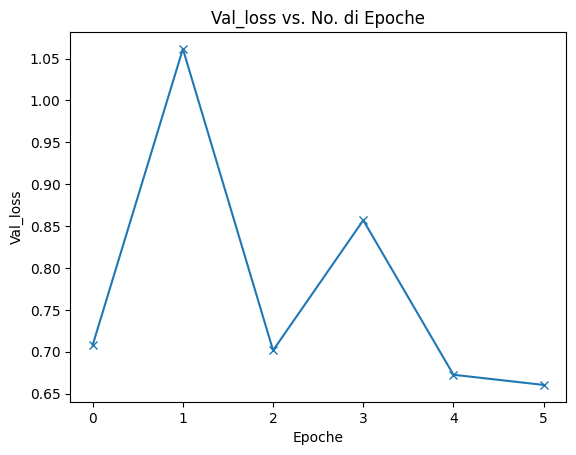

In [52]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('Epoche')
plt.ylabel('Val_loss')
plt.title('Val_loss vs. No. di Epoche')

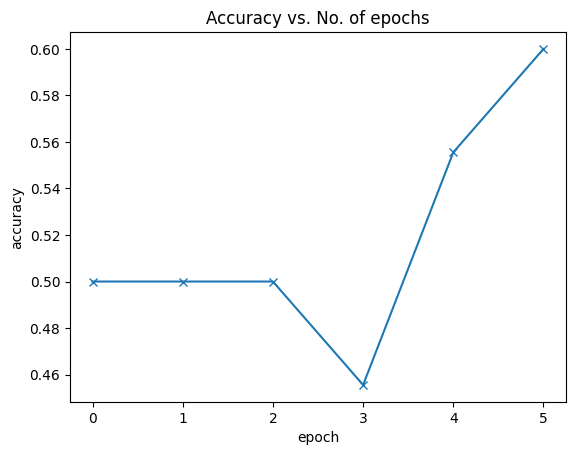

In [53]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

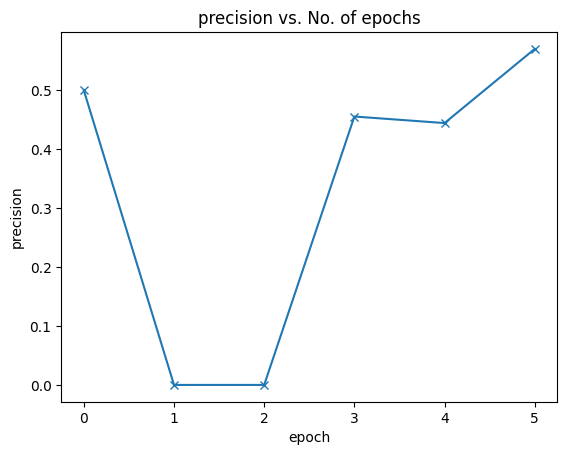

In [54]:
precision1 = [x['val_prec'] for x in history]
plt.plot(precision1, '-x')
plt.xlabel('epoch')
plt.ylabel('precision')
plt.title('precision vs. No. of epochs');

TESTING

In [55]:
test_loader = DeviceDataLoader(test_dl, device)

In [56]:
print (test_loader.device)

cpu


SALVA IL  MODELLO

In [57]:
model_path= '/content/drive/MyDrive/model.pth'
torch.save(model.state_dict(), model_path)

In [58]:
print(model.state_dict())

OrderedDict([('linear1.weight', tensor([[ 6.3529e-04, -2.1947e-04, -7.4667e-04,  ..., -4.4842e-04,
         -4.1174e-04,  1.1884e-03],
        [-1.3601e-03, -9.1271e-04, -1.7238e-03,  ..., -1.5006e-03,
         -1.4000e-03, -1.3154e-03],
        [-2.4953e-03,  5.7755e-04,  7.5570e-04,  ...,  2.3375e-04,
         -4.0253e-04, -1.6720e-04],
        ...,
        [-2.5135e-04,  9.6492e-06, -1.5611e-04,  ..., -8.8248e-04,
          2.5592e-06, -1.4179e-04],
        [-3.6518e-04,  1.0419e-03,  9.1289e-04,  ...,  5.1977e-04,
          5.2685e-04, -1.5554e-04],
        [ 5.7060e-04,  1.6871e-04,  2.9040e-04,  ...,  1.1962e-04,
         -1.5502e-05, -7.8066e-06]])), ('linear1.bias', tensor([-9.5274e-04,  1.1024e-03,  5.2060e-05,  2.5729e-06,  3.5562e-04,
        -4.8030e-04, -4.8714e-04,  1.3407e-07, -5.4828e-04,  1.2096e-06,
         2.3577e-04,  2.7057e-05,  3.2036e-06, -6.4002e-05,  3.2193e-04,
         2.1510e-06, -2.7563e-04,  9.8654e-06,  1.1553e-04,  4.5549e-04,
        -3.4295e-04, -3.5

In [59]:
def prepare_batch(batch, device):
    inputs = batch['Images'][tio.DATA].to(device)
    inputs= inputs.reshape(-1,223200)
    labels = batch['OS'].to(device)
    return inputs, labels

In [60]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        return {key: to_device(value, device) for key, value in data.items()}
    elif isinstance(data, torch.Tensor):  # Assicurati che data sia un tensore PyTorch
        return data.to(device, non_blocking=True)
    else:
        return data  # Gestisci altri tipi di dati senza modificarli

In [61]:
model2 = to_device(FFN(input_size, hidden_size, hidden_size1, hidden_size2, hidden_size3, output_size), device)
model2

FFN(
  (linear1): Linear(in_features=223200, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=25, bias=True)
  (linear4): Linear(in_features=25, out_features=10, bias=True)
  (linear5): Linear(in_features=10, out_features=2, bias=True)
)

In [62]:
# load the best model checkpoint

best_model_cp = torch.load('/content/FFN.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 5 epochs



In [63]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=0.1)

# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=5,
                                                steps_per_epoch=len(train_dl))

# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [64]:
print('Loading best epoch saved model weights...')
model2.load_state_dict(best_model_cp['model_state_dict'])
# optimizer
optimizer.load_state_dict(best_model_cp['optimizer_state_dict'])
# scheduler
scheduler.load_state_dict(best_model_cp['scheduler_state_dict'])

Loading best epoch saved model weights...


In [65]:
test = [evaluate(model2, test_loader)]
test



outputs dei due neuroni:  tensor([[-7.4454, -6.8483],
        [-6.7581, -6.4166],
        [-5.7712, -5.7141],
        [-7.1170, -6.8104],
        [-5.8290, -5.9841],
        [-8.8300, -8.3776],
        [-7.1393, -6.5461],
        [-6.8569, -6.4033],
        [-6.6242, -6.7668],
        [-8.1101, -7.6906]])

precision preds:  tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

precision targets:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

validation step loss:  tensor(0.5662)

validation step accuracy:  tensor(0.8000)

validation step precision:  tensor(1.)

outputs dei due neuroni:  tensor([[-6.4112, -6.0442],
        [-6.4120, -6.4021],
        [-7.3438, -7.2031],
        [-6.2499, -6.5535],
        [-7.2536, -6.7389],
        [-7.0813, -6.8112],
        [-6.4120, -6.4021],
        [-7.5510, -7.3723],
        [-6.5380, -6.5954],
        [-7.0033, -7.0181]])

precision preds:  tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0])

precision targets:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

validation step loss:  te

[{'val_loss': 0.6609611511230469,
  'val_acc': 0.574999988079071,
  'val_prec': 0.5}]

In [66]:
#test_dl = DataLoader(test_ds, num_workers=0) # CAMBIATO PER FARE IL TEST SU TUTTO

In [67]:
test_dl = DataLoader(test_ds, num_workers=0)

test_dl = DataLoader(test_ds, batch_size= 11)

In [68]:
test_loader = DeviceDataLoader(test_dl, device)

In [69]:
print (test_loader.device)

cpu


In [70]:
import random

In [71]:
subj= random.choice(test_ds)

In [72]:
print(test_ds)

In [73]:
input_tensor= subj['Images'][tio.DATA].to(device)
input_tensor.shape

torch.Size([6, 30, 40, 31])

In [74]:
input_tensor=subj['Images'][tio.DATA].reshape(-1,223200).to(device)
print(input_tensor.shape)

torch.Size([1, 223200])


In [75]:
model_path= '/content/drive/MyDrive/model.pth'
torch.save(model.state_dict(), model_path)

In [76]:
print(model.state_dict())

OrderedDict([('linear1.weight', tensor([[ 6.3529e-04, -2.1947e-04, -7.4667e-04,  ..., -4.4842e-04,
         -4.1174e-04,  1.1884e-03],
        [-1.3601e-03, -9.1271e-04, -1.7238e-03,  ..., -1.5006e-03,
         -1.4000e-03, -1.3154e-03],
        [-2.4953e-03,  5.7755e-04,  7.5570e-04,  ...,  2.3375e-04,
         -4.0253e-04, -1.6720e-04],
        ...,
        [-2.5135e-04,  9.6492e-06, -1.5611e-04,  ..., -8.8248e-04,
          2.5592e-06, -1.4179e-04],
        [-3.6518e-04,  1.0419e-03,  9.1289e-04,  ...,  5.1977e-04,
          5.2685e-04, -1.5554e-04],
        [ 5.7060e-04,  1.6871e-04,  2.9040e-04,  ...,  1.1962e-04,
         -1.5502e-05, -7.8066e-06]])), ('linear1.bias', tensor([-9.5274e-04,  1.1024e-03,  5.2060e-05,  2.5729e-06,  3.5562e-04,
        -4.8030e-04, -4.8714e-04,  1.3407e-07, -5.4828e-04,  1.2096e-06,
         2.3577e-04,  2.7057e-05,  3.2036e-06, -6.4002e-05,  3.2193e-04,
         2.1510e-06, -2.7563e-04,  9.8654e-06,  1.1553e-04,  4.5549e-04,
        -3.4295e-04, -3.5

In [77]:
model.eval()

with torch.no_grad():
  probabilities = model(input_tensor)

In [78]:
probabilities.shape

torch.Size([1, 2])

In [79]:
#print(probabilities)

In [80]:
_, preds = torch.max(probabilities, dim=1)

In [81]:
preds

tensor([1])

In [82]:
predicted_label = preds[0].item()

In [83]:
label_true= subj['OS']

In [84]:
print('label predicted:', predicted_label, 'label_true:',label_true)

label predicted: 1 label_true: 0
